In [ ]:
import pandas as pd
import numpy as np
import re
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

import tensorflow as tf
from tensorflow import keras

from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


A 'Ar XIV' é um repositório gratuito de trabalhos científicos, os trabalhos podem receber classificações conforme o link: https://arxiv.org/category_taxonomy. A ideia inicial do trabalho é fazer um filtro na coluna *'terms'* com os seguintes objetivos:

*  Realizar uma captação das classificações no site da 'Ar XIV'; 
*  Filtrar na coluna *'terms'* as classificações que não fazem parte do 'Ar XIV';
*  Excluir todas as instâncias que aparecem menos de 300 vezes no projeto.

Como resultados teremos a coluna *terms* apenas com as classificações que fazem parte do site da 'Ar XIV' e aparecem no mínimo 301 vezes.

O Objetivo dessa estrategia é a remoção de outliers e redução do espaço amostral para que o modelo tenha maior facilidade de classificação.

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/arxiv_data.csv')
df.head()
df.drop_duplicates(subset=['titles'], inplace=True)
df.reset_index(inplace=True, drop = True)
#Loop responsável por excluir todos os caracteres especiais
for i in range(len(df)):
    df.loc[i, 'terms'] = re.sub(r'[^\w\s]', '', df.loc[i, 'terms'])

In [ ]:
class TermsCleaning:
    
    def __init__(self, dataframe, classif_list, column):
        self.dataframe = dataframe
        self.classif_list = classif_list
        self.column = column

    # Função responsável por retirar o ponto das variáveis terms
    def clear_dot(lista): 
        lista = np.array(lista)
        for i in range(len(lista)):
            x = str(lista[i])
            y = re.findall('\w', x)
            lista[i] = ''.join(y)
        return lista

    # Função responsável por limpar as classificações do ArXIV de acordo com uma lista classificadora
    # Essa lista não checa a combinação das classificações e sim as classificações unitárias
    # Ver: https://arxiv.org/category_taxonomy para mais informações.
    def clear_class(dataframe,classificator, column):
        for j in range(len(dataframe)):
            sentence = np.array(dataframe.loc[j, column].split()) #Transforma a string classificação em lista
            indices=np.argwhere(np.isin(sentence,classificator))  #Procura os índices que estão dentro do classificador
            delete = []
            for i in range(len(sentence)):
                if i not in indices:
                    delete.append(i)
            dataframe.loc[j, column] = str(np.delete(sentence, delete))
        return dataframe

    #Função responsável por criar uma lista de dummies.
    def dummies(dataframe,lista):
        dummies = pd.get_dummies(lista)[0:0]
        #Este loop coloca 1 caso uma classificação esteja dentro da classificação dos dummies, caso não esteja, é preenchido como NaN
        for x in range(len(dataframe)):
            classif_main = dataframe.loc[x, 'terms'].split()
            for i in dummies.columns:
                for j in classif_main:
                    if i in j:
                        dummies.loc[x, i] = 1
        dummies.fillna(0, inplace = True)
        return dummies

    #Função responsável por executar as funções acima e retornar um dataframe com a coluna 'terms' filtrada 
    def cleaner(self):
        classif_list = TermsCleaning.clear_dot(self.classif_list)
        classif_list = TermsCleaning.dummies(self.dataframe,classif_list)
        total_dummies = []
        # Esse loop é responsável por gerar uma contagem dos totais da coluna especificada

        for i in classif_list.columns:
            counts = np.sum(classif_list[i])
            total_dummies.append([i,counts]) 
        total_dummies = pd.DataFrame(total_dummies, columns = ['Classification','Total'])

        # Loop responsável por excluir todas as instâncias que são inferiores a 300
        for i in range(len(total_dummies)):
            if total_dummies.loc[i, 'Total'] <= 300:
                total_dummies.drop(i, inplace = True)
        total_dummies.reset_index(drop=True, inplace=True)
        total_dummies_numpy = np.array(total_dummies['Classification'])
        df_selected_dummies = TermsCleaning.clear_class(self.dataframe, total_dummies_numpy, self.column)
        new_dummies = TermsCleaning.dummies(dataframe = df_selected_dummies,lista = total_dummies_numpy)
        return df_selected_dummies , new_dummies, total_dummies

In [ ]:
#web scraping das classificações originais
page = requests.get('https://arxiv.org/category_taxonomy')
soup = BeautifulSoup(page.content, 'html.parser')
htmlclass = 'div[class="column is-one-fifth"]'
container = soup.select(htmlclass)

# Extraindo texto do código html original
h4class = re.findall('(<.*?>)(.*)(<.*?>)', str(container))
h4class = pd.DataFrame(h4class)

h4class.drop(columns = {0,2}, inplace = True)

classif_list = []
# Limpeza dos dados
# Criando uma lista de classificações
for i in range(len(h4class)):
    x = h4class.loc[i, 1].split()[0]
    notclass = [',','Condensed','High','Mathematical','Nonlinear','Nuclear','Quantum','General','span']
    if x in notclass:
        continue
    else:
        classif_list.append(x)

In [ ]:
cleaner = TermsCleaning(dataframe = df, classif_list = classif_list, column = 'terms')
df , y , total = cleaner.cleaner()

In [ ]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
mlb = MultiLabelBinarizer()
vectorizer = CountVectorizer(analyzer='word', ngram_range=(1,1))
tfidf_transformer = TfidfTransformer()

In [ ]:
titles = df['titles']

In [ ]:
# funcao para tratar cada palavra e remover stopwords
def processamento(tokens):
    
    token_processado = []
    for token in tokens:
        token = token.lower()
        token = lemmatizer.lemmatize(token)
        
        if token not in stop_words:
            token = stemmer.stem(token)
            token_processado.append(token)
        
    return token_processado

documentos_1 = []
for title in titles:
    
    # expressao regular para remover pontuacoes do texto
    title = re.sub(r'[^\w\s]','', title)
    tokens = processamento(word_tokenize(title))
    
    documentos_1.append(' '.join(tokens))

X_train_counts_1 = vectorizer.fit_transform(documentos_1)
X_train_tfidf_1 = tfidf_transformer.fit_transform(X_train_counts_1)

X_1 = X_train_tfidf_1

In [ ]:
pd.DataFrame(total).reset_index(drop=True).sort_values(by=['Total'], ascending = False).T

,3,6,16,0,13,10,1,9,2,15,14,4,11,12,8,5,7
Classification,csCV,csLG,statML,csAI,eessIV,csRO,csCL,csNE,csCR,mathOC,eessSP,csGR,csSI,csSY,csMM,csIR,csMA
Total,22253.0,22241.0,12425.0,5951.0,1762.0,1493.0,1095.0,1014.0,590.0,583.0,480.0,446.0,430.0,387.0,385.0,351.0,304.0


Text(0.5, 1.0, 'Classification totals')

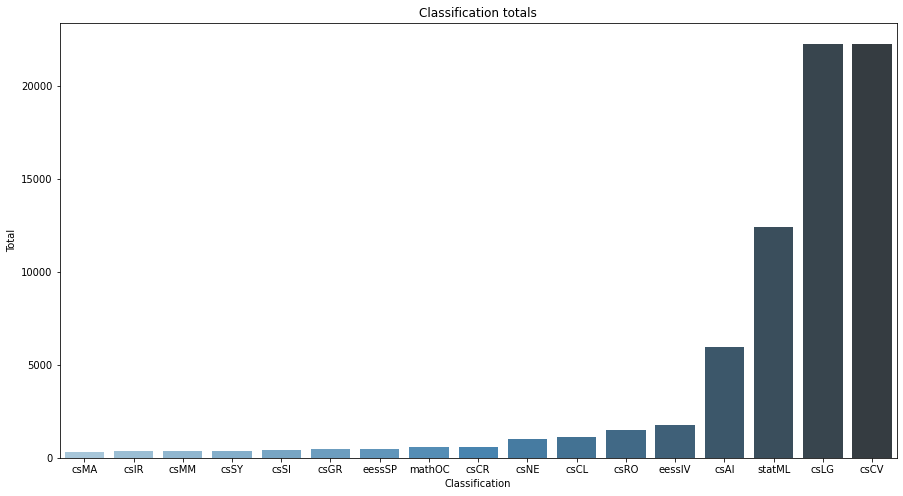

In [ ]:
total.sort_values(by = ['Total'], inplace = True)
plt.figure(figsize = (15,8))
sns.barplot(data = total, x = 'Classification', y = 'Total',palette="Blues_d")
plt.title('Classification totals')

In [ ]:
#Construção do PCA
pca = TruncatedSVD(n_components = 100, algorithm='arpack', random_state = 10, tol = 0.1)
X_pca_1 = pca.fit_transform(X_1)

In [ ]:
Xtrain_1, Xtest_1,Ytrain_1, Ytest_1 = train_test_split(X_pca_1, y, test_size=0.20, random_state=10)

In [ ]:
#SVM
svm_1 = SGDClassifier(loss='hinge', penalty='l2',learning_rate='adaptive', random_state=10, eta0=0.05, )
clf_svm_1 = OneVsRestClassifier(svm_1)

clf_svm_1.fit(Xtrain_1, Ytrain_1)
y_pred_svm_1 = clf_svm_1.predict(Xtest_1)

In [ ]:
acc_svm_1 = round(accuracy_score(Ytest_1, y_pred_svm_1),4)
prec_svm_1 = round(precision_score(Ytest_1, y_pred_svm_1,average = 'micro'),4)
roc_svm_1 =  round(roc_auc_score(Ytest_1, y_pred_svm_1),4)

In [ ]:
print(f'Accuracy for logistic regression: {acc_svm_1}')
print(f'Precision for logistic regression: {prec_svm_1} ' )
print(f'ROC AUC for logistic regression: {roc_svm_1} ', )

Accuracy for logistic regression: 0.3697
Precision for logistic regression: 0.8178 
ROC AUC for logistic regression: 0.5462 


In [ ]:
#Logistic Regression
lr_1 = LogisticRegression(solver='sag', multi_class='ovr')
clf_lr_1 = OneVsRestClassifier(lr_1)

clf_lr_1.fit(Xtrain_1, Ytrain_1)
y_pred_lr_1 = clf_lr_1.predict(Xtest_1)
y_pred_lr_prob_1 = clf_lr_1.predict_proba(Xtest_1)

In [ ]:
acc_lr_1 = round(accuracy_score(Ytest_1, y_pred_lr_1),4)
prec_lr_1 = round(precision_score(Ytest_1, y_pred_lr_1,average = 'micro'),4)
roc_lr_1 =  round(roc_auc_score(Ytest_1, y_pred_lr_prob_1),4)

In [ ]:
print(f'Accuracy for logistic regression: {acc_lr_1}')
print(f'Precision for logistic regression: {prec_lr_1} ' )
print(f'ROC AUC for logistic regression: {roc_lr_1} ', )

Accuracy for logistic regression: 0.3851
Precision for logistic regression: 0.7995 
ROC AUC for logistic regression: 0.8296 


In [ ]:
#Neural Network
# O código é composto pelas seguintes camadas:
# 1. Input com o número de neuronios igual ao número de features (número de palavras)
# 2. Camada de dropout com 0.2 de probabilidade
# 3. Camada com achatamento
# 4. Camada densa com metade do numero de neuronios da camada de input
# 5. Camada densa com um quarto (1/4) do numero de neuronios da camada de input repetido duas vezes
# 6. Camada densa com um oitavo (1/8) do numero de neuronios da camada de input
# 7. Camada densa de output com um neuronio para cada classe com ativação softmax

model_1 = keras.Sequential(
    [keras.layers.Dense(Xtrain_1.shape[-1], activation="relu", input_shape=(Xtrain_1.shape[-1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(Xtrain_1.shape[-1]/2, activation="relu"),
    keras.layers.Dense(Xtrain_1.shape[-1]/4, activation="relu"),
    keras.layers.Dense(Xtrain_1.shape[-1]/4, activation="relu"),
    keras.layers.Dense(Xtrain_1.shape[-1]/8, activation="relu"),
    keras.layers.Dense(y.shape[1], activation="softmax"),
    ]
)

model_1.summary()

model_1.compile(optimizer= keras.optimizers.Adam(0.0015), loss='binary_crossentropy' ,metrics=[tf.keras.metrics.AUC(name='auc'),keras.metrics.Precision(name = 'precision'),keras.metrics.CategoricalAccuracy(name = 'accuracy')])
history_1 = model_1.fit(Xtrain_1, Ytrain_1, batch_size=10, epochs=35)

print("\n")
scoreMLP_1 = model_1.evaluate(Xtrain_1, Ytrain_1)
print(model_1.metrics_names)
print("Loss: ", scoreMLP_1[0])
print("AUC for neural network: ", scoreMLP_1[1])
print("Precision for neural network: ", scoreMLP_1[2])
print("Accuracy for neural network: ", scoreMLP_1[3])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               10100     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 flatten (Flatten)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 25)                650       
                                                                 
 dense_4 (Dense)             (None, 12)                3

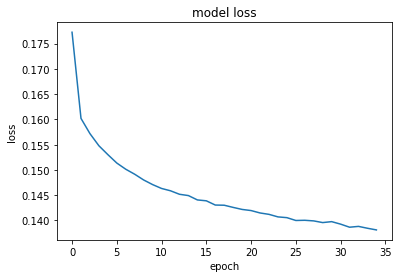

In [ ]:
# Gráfico da perda versus as épocas
plt.plot(history_1.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

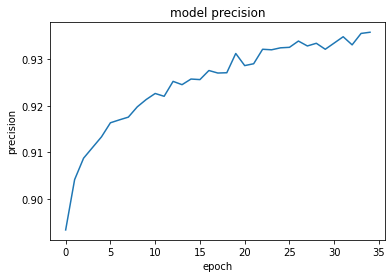

In [ ]:
# Gráfico da precisão versus as épocas
plt.plot(history_1.history["precision"])
plt.title("model precision")
plt.ylabel("precision")
plt.xlabel("epoch")
plt.show()

In [ ]:
model1 = [[acc_lr_1,prec_lr_1,roc_lr_1],[acc_svm_1,prec_svm_1,roc_svm_1],[round(scoreMLP_1[3],4),round(scoreMLP_1[1],4),round(scoreMLP_1[2],4)]]
metrics_1 = pd.DataFrame(model1, columns = ['Acurracy','AUC','Precision'], index = ['Logistic Regression', 'SVM', 'Neural Network'])
metrics_1.columns = pd.MultiIndex.from_product([['title'], metrics_1.columns])
metrics_1

title                  
                    Acurracy     AUC Precision
Logistic Regression   0.3851  0.7995    0.8296
SVM                   0.3697  0.8178    0.5462
Neural Network        0.7121  0.9152    0.9501

Como é possível observar, a métrica dependeu bastante do modelo utilizado.

1. Regressão logística

A regressão logística apresentou baixa acurácia, porém obteve altas métricas na curva AUC e na precisão.

2. SVM

Mostro um bom desenho acerca da curva AUC, porém as outras métricas não conseguiram obter um bom desempenho.

3. Rede Neural

Foi o com melhor desempenho, obteve um número razoável para a acurácia e ótimo quando comparado com os dois modelos anteriores, em relação ao AUC, obteve a maior métrica em relação aos outros e em relação à precisão obteve ótimos resultados, e como é possível verificar pelo gráfico *model precision* obteve um bom aprendizado em relação à precisão.

## Títulos

In [ ]:
abstracts = df['summaries']

In [ ]:
# funcao para tratar cada palavra e remover stopwords
def processamento(tokens):
    
    token_processado = []
    for token in tokens:
        token = token.lower()
        token = lemmatizer.lemmatize(token)
        
        if token not in stop_words:
            token = stemmer.stem(token)
            token_processado.append(token)
        
    return token_processado

documentos_2 = []
for abstract in abstracts:
    
    # expressao regular para remover pontuacoes do texto
    abstract = re.sub(r'[^\w\s]','', abstract)
    tokens = processamento(word_tokenize(abstract))
    
    documentos_2.append(' '.join(tokens))

X_train_counts_2 = vectorizer.fit_transform(documentos_2)
X_train_tfidf_2 = tfidf_transformer.fit_transform(X_train_counts_2)

X2 = X_train_tfidf_2

In [ ]:
pca = TruncatedSVD(n_components = 100, algorithm='arpack', random_state = 10, tol = 0.1)
X_pca_2 = pca.fit_transform(X2)

In [ ]:
Xtrain_2, Xtest_2,Ytrain_2, Ytest_2 = train_test_split(X_pca_2, y, test_size=0.20, random_state=10)

In [ ]:
#SVM
svm_2 = SGDClassifier(loss='hinge', penalty='l2',learning_rate='adaptive', random_state=10, eta0=0.05, )
clf_svm_2 = OneVsRestClassifier(svm_2)

clf_svm_2.fit(Xtrain_2, Ytrain_2)
y_pred_svm_2 = clf_svm_2.predict(Xtest_2)

In [ ]:
acc_svm_2 = round(accuracy_score(Ytest_2, y_pred_svm_2),4)
prec_svm_2 = round(precision_score(Ytest_2, y_pred_svm_2,average = 'micro'),4)
roc_svm_2 =  round(roc_auc_score(Ytest_2, y_pred_svm_2),4)

In [ ]:
print(f'Accuracy for logistic regression: {acc_svm_2}')
print(f'Precision for logistic regression: {prec_svm_2}')
print(f'ROC AUC for logistic regression: {roc_svm_2}')

Accuracy for logistic regression: 0.4473
Precision for logistic regression: 0.8554
ROC AUC for logistic regression: 0.559


In [ ]:
# Logistic Regression
lr_2 = LogisticRegression(solver='sag', multi_class='ovr')
clf_lr_2 = OneVsRestClassifier(lr_2)

clf_lr_2.fit(Xtrain_2, Ytrain_2)
y_pred_lr_2 = clf_lr_2.predict(Xtest_2)
y_pred_prob_lr_2 = clf_lr_2.predict_proba(Xtest_2)

In [ ]:
acc_lr_2 = round(accuracy_score(Ytest_2, y_pred_lr_2),4)
prec_lr_2 = round(precision_score(Ytest_2, y_pred_lr_2,average = 'micro'),4)
roc_lr_2 =  round(roc_auc_score(Ytest_2, y_pred_prob_lr_2),4)

In [ ]:
print(f'Accuracy for logistic regression: {acc_lr_2}')
print(f'Precision for logistic regression: {prec_lr_2} ' )
print(f'ROC AUC for logistic regression: {roc_lr_2} ', )

Accuracy for logistic regression: 0.4373
Precision for logistic regression: 0.8357 
ROC AUC for logistic regression: 0.8928 


In [ ]:
#Neural Network
# O código é composto pelas seguintes camadas:
# 1. Input com o número de neuronios igual ao número de features (número de palavras)
# 2. Camada de dropout com 0.2 de probabilidade
# 3. Camada com achatamento
# 4. Camada densa com metade do numero de neuronios da camada de input
# 5. Camada densa com um quarto (1/4) do numero de neuronios da camada de input repetido duas vezes
# 6. Camada densa com um oitavo (1/8) do numero de neuronios da camada de input
# 7. Camada densa de output com um neuronio para cada classe com ativação softmax

model_2 = keras.Sequential(
    [keras.layers.Dense(Xtrain_1.shape[-1], activation="relu", input_shape=(Xtrain_1.shape[-1],)),
    keras.layers.Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(Xtrain_1.shape[-1]/2, activation="relu"),
    keras.layers.Dense(Xtrain_1.shape[-1]/4, activation="relu"),
    keras.layers.Dense(Xtrain_1.shape[-1]/4, activation="relu"),
    keras.layers.Dense(Xtrain_1.shape[-1]/8, activation="relu"),
    keras.layers.Dense(y.shape[1], activation="softmax"),
    ]
)

model_2.summary()

model_2.compile(optimizer= keras.optimizers.Adam(0.005), loss="binary_crossentropy" ,metrics=[tf.keras.metrics.AUC(name='auc'),keras.metrics.CategoricalAccuracy(name = 'accuracy'),keras.metrics.Precision(name = 'precision')])
history_2 = model_2.fit(Xtrain_2, Ytrain_2, batch_size=10, epochs=35)

print("\n")
scoreMLP_2 = model_2.evaluate(Xtrain_2, Ytrain_2)
print(model_2.metrics_names)
print("Loss: ", scoreMLP_2[0])
print("AUC for neural network: ", scoreMLP_2[1])
print("Precision for neural network: ", scoreMLP_2[3])
print("Accuracy for neural network: ", scoreMLP_2[2])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 100)               10100     
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 flatten_1 (Flatten)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 50)                5050      
                                                                 
 dense_8 (Dense)             (None, 25)                1275      
                                                                 
 dense_9 (Dense)             (None, 25)                650       
                                                                 
 dense_10 (Dense)            (None, 12)               

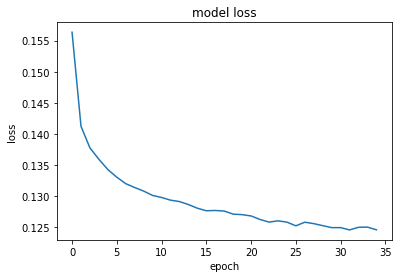

In [ ]:
plt.plot(history_2.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

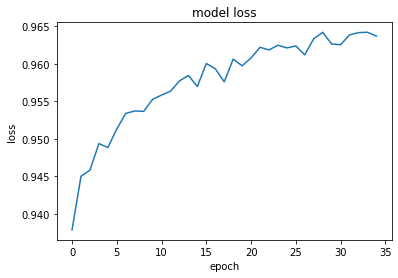

In [ ]:
plt.plot(history_2.history["precision"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
model2 = [[acc_lr_2,prec_lr_2,roc_lr_2],[acc_svm_2,prec_svm_2,roc_svm_2],[round(scoreMLP_2[2],4),round(scoreMLP_2[1],4),round(scoreMLP_2[3],4)]]
metrics_2 = pd.DataFrame(model2, columns = ['Acurracy','AUC','Precision'], index = ['Logistic Regression', 'SVM', 'Neural Network'])
metrics_2.columns = pd.MultiIndex.from_product([['abstract'], metrics_2.columns])
metrics_2

abstract                  
                    Acurracy     AUC Precision
Logistic Regression   0.4373  0.8357    0.8928
SVM                   0.4473  0.8554    0.5590
Neural Network        0.7388  0.8863    0.9714

In [ ]:
metrics = pd.concat([metrics_2,metrics_1], axis = 1)
metrics

abstract                      title                  
                    Acurracy     AUC Precision Acurracy     AUC Precision
Logistic Regression   0.4373  0.8357    0.8928   0.3851  0.7995    0.8296
SVM                   0.4473  0.8554    0.5590   0.3697  0.8178    0.5462
Neural Network        0.7388  0.8863    0.9714   0.7121  0.9152    0.9501